# Clasificación Taxonómica

## Descripción de Muestra

### SRR606249 — Descripción del Conjunto de Datos
SRR606249 es una corrida de secuenciación de acceso público depositada en el Archivo de Lecturas de Secuencia (SRA) del NCBI. Contiene lecturas metagenómicas *shotgun* de Illumina en formato *paired-end*, generadas a partir de una comunidad bacteriana “mock” definida. Una comunidad *mock* es una mezcla construida en laboratorio que combina varias especies bacterianas en proporciones conocidas. La muestra se secuenció sin amplificación previa (preparación de biblioteca *shotgun*), lo que produce una mezcla heterogénea de fragmentos cortos de ADN procedentes de los genomas de todos los organismos presentes en la comunidad.

Características principales (https://trace.ncbi.nlm.nih.gov/Traces/index.html?view=run_browser&acc=SRR606249):

* Accesión: SRR606249
* ormato: Illumina *paired-end*, FASTQ sin procesar
* Tipo de lectura: Secuenciación metagenómica *shotgun*
* Contenido: ADN genómico mezclado de varias especies bacterianas

### Descargar Muestra

Ese fragmento de R cambia primero a la carpeta *Bioseq-identification/data/raw* y luego ejecuta dos comandos externos: uno descarga del SRA la muestra SRR60624 mediante *prefetch*, y el otro convierte la muestra SRR606249 a archivos FASTQ usando *fasterq-dump*, separando lecturas forward y reverse y guardándolas en la carpeta *metagenome*; en resumen, prepara y transforma datos de secuenciación para su análisis posterior.

In [10]:
basepath <- "Bioseq-identification"
setwd(file.path(basepath, "/data/raw"))
system("prefetch SRR60624")
system("fasterq-dump SRR606249 --split-files -O metagenome/")

ERROR: Error in parse(text = input): <text>:2:8: unexpected symbol
1: basepath <- "
2: setwd("Bioseq
          ^


### Construir o Descargar la Biblioteca de Clasificación

Ese bloque crea una carpeta llamada *gtdb_r89_54k_kraken2_04gb* y dentro de ella construye una base de datos de **Kraken2**: primero descarga la taxonomía completa, luego baja las secuencias de bacterias y arqueas, y al final ensambla todo en una base de datos utilizable para clasificar lecturas metagenómicas.

In [ ]:
system("mkdir gtdb_r89_54k_kraken2_04gb")
system("kraken2-build --download-taxonomy --db gtdb_r89_54k_kraken2_04gb")
system("kraken2-build --download-library bacteria --db gtdb_r89_54k_kraken2_04gb")
system("kraken2-build --download-library archaeal --db gtdb_r89_54k_kraken2_04gb")
system("kraken2-build --build --db gtdb_r89_54k_kraken2_04gb")

Alternativamente, la muestra puede descargarse desde [https://bridges.monash.edu/articles/dataset/GTDB_r89_54k/8956970](https://bridges.monash.edu/articles/dataset/GTDB_r89_54k/8956970) y descomprimirse.

In [ ]:
system("tar -xvf gtdb_r89_54k_kraken2_04gb.tar")

### Analizar la Muestra
Esta celda guarda un comando de Kraken2 en una cadena multilínea llamada `cmd` y luego lo ejecuta. El comando utiliza la base de datos *gtdb_r89_54k_kraken2_04gb*, toma los archivos FASTQ pareados del directorio *metagenome* y genera tanto un informe de clasificación (`kraken.report`) como un archivo de resultados completos (`kraken.output`). Al llamar a `system(cmd)`, todo ese comando se envía al sistema para su ejecución.

In [ ]:
cmd <- r"(
kraken2 --db gtdb_r89_54k_kraken2_04gb \
    --paired metagenome/SRR606249_1.fastq \
            metagenome/SRR606249_2.fastq \
    --report metagenome/kraken.report \
    --output metagenome/kraken.output
)"
system(cmd)

### Visualizar la Muestra
Este fragmento carga *tidyverse*, selecciona en la tabla `kraken` los diez taxones con mayor porcentaje (`pct_clade`) y los guarda en `top10`, y luego construye con `ggplot2` un gráfico en anillo: las columnas se dibujan en coordenadas polares, se abre un hueco interior ajustando `xlim`, se elimina la decoración visual con `theme_void`, y se muestra una leyenda a la derecha junto con un título que indica que se representan los taxones más abundantes según Kraken2.

In [13]:
library(tidyverse)
library(readr)

basepath <- "/home/porvik/work/ipc/Bioseq-identification"
setwd(file.path(basepath, "/data/raw/metagenome"))

kraken <- read_tsv(
  "kraken.report",
  col_names = c("pct_clade","reads_clade","reads_direct",
                "rank_code","taxid","name_raw"),
  show_col_types = FALSE
) %>%
mutate(Name = str_trim(name_raw))

head(kraken)

pct_clade,reads_clade,reads_direct,rank_code,taxid,name_raw,Name
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
71.41,39144740,39144740,U,0,unclassified,unclassified
28.59,15670008,67456,R,1,root,root
22.27,12208471,78820,D,3,Bacteria,Bacteria
4.09,2240065,17755,P,110,Proteobacteria,Proteobacteria
2.06,1131479,13946,C,282,Gammaproteobacteria,Gammaproteobacteria
1.71,937547,4702,O,619,Burkholderiales,Burkholderiales


Esta celda toma la tabla `kraken`, selecciona los diez taxones con mayor porcentaje asignado (`pct_clade`) y les añade una etiqueta con el porcentaje redondeado. Después genera un gráfico en anillo con `ggplot2`: las barras se transforman en sectores circulares mediante coordenadas polares, cada sector lleva una etiqueta centrada con su porcentaje, y el fondo del gráfico se deja transparente para facilitar su uso en imágenes o presentaciones. La leyenda se sitúa a la derecha y se añade un título y subtítulo que explican que se muestran los taxones más abundantes según Kraken2.

Warning message in geom_text(aes(label = label), position = position_stack(vjust = 0.5), :
“Ignoring unknown parameters: `stroke` and `linewidth`”


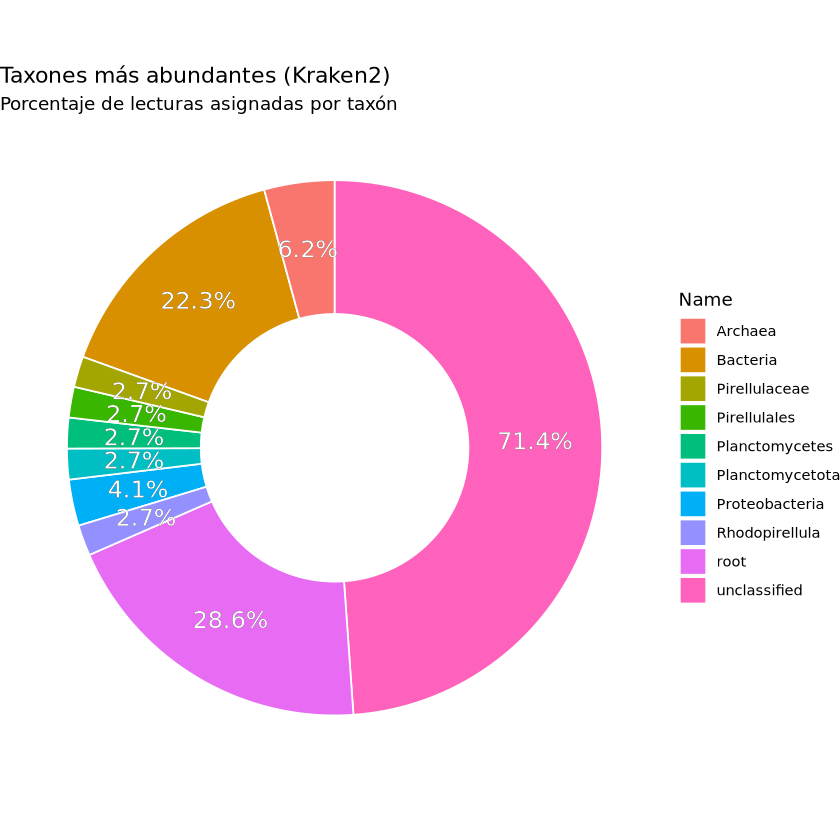

In [22]:
library(tidyverse)

p <- ggplot(top10, aes(x = 2, y = pct_clade, fill = Name)) +
  geom_col(color = "white", width = 1) +

  # Sombra negra (outline)
  geom_text(
    aes(label = label),
    position = position_stack(vjust = 0.5),
    color = "black",
    size = 5,
    stroke = 0.6,
    linewidth = 1
  ) +

  # Texto blanco encima
  geom_text(
    aes(label = label),
    position = position_stack(vjust = 0.5),
    color = "white",
    size = 5
  ) +

  coord_polar(theta = "y") +
  xlim(0.5, 2.5) +
  theme_void() +
  theme(
    legend.position = "right",
    plot.background = element_rect(fill = NA, color = NA),
    panel.background = element_rect(fill = NA, color = NA)
  ) +
  ggtitle(
    "Taxones más abundantes (Kraken2)",
    subtitle = "Porcentaje de lecturas asignadas por taxón"
  )

p